# Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = "w"

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

# Carga de datos

Se importan los datos, idem script "Demanda y variables de influencia".

In [2]:
file_list = ['19012132.csv',
             '19012066.csv',
             '19012806.csv',
             '19012671.csv',
             '19012015.csv',
             '19012717.csv',
             '17832734.csv',
             '19012613.csv',
             '19011933.csv',
             '19012099.csv',
             '19012038.csv',
             '19012609.csv',
             '19011884.csv',
             '19012858.csv',
             '19012736.csv',
             '19012911.csv',
             '18417696.csv',
             '19011846.csv',
             '18417662.csv',
             '19011943.csv',
             '18718780.csv',
             '19012795.csv',
             '19012738.csv',
             '19011932.csv',
             '19012663.csv',
             'verano_cluster_1.csv'
            ]

main_dataframe = pd.read_csv(file_list[0])

for i in range(1, len(file_list)):
    df = pd.read_csv(file_list[i])
    main_dataframe = pd.concat([main_dataframe, df])
    
### cambio el nombre de las columnas ###

main_dataframe.columns = ['meter', 'timestamp', 'load']

### formateo la columna Data_Time ###

main_dataframe['timestamp'] = pd.to_datetime(main_dataframe.timestamp, format='%Y-%m-%d %H:%M:%S')

### elimino dupliclados ###

main_dataframe=main_dataframe.drop_duplicates()

### fecha de estudio ###

df = main_dataframe.query("timestamp > '2021-03-21' and timestamp <='2022-03-21'")

# CURVA AGREGADA DE USUARIOS

ts=df.drop(['meter'],axis=1).groupby('timestamp', as_index=False).sum().set_index('timestamp')
df.to_excel('curvas.xlsx')

# TEMPERATURAS

temp = pd.read_excel('Temperatura SOTR.xls',sheet_name='Sheet1')

### cambio el nombre de las columnas ###

temp.columns = ['timestamp', 'Area','medicion','temp']

temp['timestamp'] = pd.to_datetime(temp.timestamp, format='%Y-%m-%d %H:%M:%S')

### fecha de estudio ###

temp = temp.query("medicion =='GRAL. RODRIGUEZ' and timestamp >= '2021-03-21' and timestamp <='2022-03-21'").drop(['Area','medicion'],axis=1).set_index('timestamp')
temp = pd.Series(temp['temp'].values, index=temp.index).rename('T')

# colores
blue = sns.color_palette("muted", desat=0.9)[0]
green = sns.color_palette("muted", desat=0.9)[2]
red = sns.color_palette("muted", desat=0.9)[3]
grey = sns.color_palette("muted", desat=0.9)[7]

temp.head(3)

timestamp
2021-03-21 01:00:00    15.578170
2021-03-21 02:00:00    14.955588
2021-03-21 03:00:00    14.833515
Name: T, dtype: float64

Se trabaja con resolución horaria, pero tengo un dato null que lo lleno haciendo un promedio entre el valor anterior y el posterior

In [3]:
# SAVE TARGET AS y
y = ts.resample("H").mean().copy()
null_columns=y.columns[y.isnull().any()]
y[null_columns].isnull().sum()
print(y[y.isnull().any(axis=1)][null_columns].head())

y.loc['2021-11-25 07:00:00'] = ((y.loc['2021-11-25 06:00:00']+y.loc['2021-11-25 08:00:00'])/2)

y = pd.Series(y['load'].values, index=y.index).rename('y')

                     load
timestamp                
2021-11-25 07:00:00   NaN


### Visualización de la serie de tiempo de la demanda en paso de 30 días

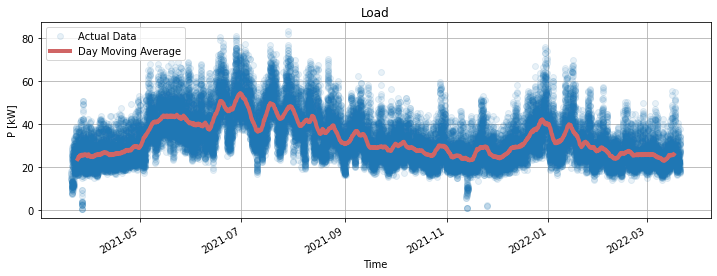

In [4]:
ts.plot(figsize=[12, 4], alpha=0.1, marker="o", linestyle="");
ts.rolling(window=30*24, center=True).mean().plot(ax=plt.gca(), color=red, lw=4);
plt.legend(["Actual Data", "Day Moving Average"])
plt.grid()
plt.xticks(), plt.yticks();
plt.xlabel("Time"), plt.ylabel("P [kW]");
plt.title("Load");


# FUNCIONES RESPALDO

In [5]:
def get_season(ts_in):

    season = pd.Series()

    for year in ts_in.index.year.unique():

        # CREATE SEASONS
        yearly_season = pd.Series("inter-season", index=ts_in.loc[str(year)].index)

        yearly_season.loc[: "{}-3-21".format(year)] = "summer"
        yearly_season.loc["{}-12-21".format(year) :] = "summer"
        yearly_season.loc["{}-6-21".format(year) : "{}-9-21".format(year)] = "winter"

        season = pd.concat([season, yearly_season])
    return season



def get_interactions(s, dummies, poly_degree=1):
    
    if s.name == None: s.name = "_"
    s1 = dummies.apply(lambda x: x * s).rename("{}".format(s.name + "_{}").format, axis=1)
    s2 = (dummies.apply(lambda x: x * s) **2).rename("{}".format(s.name + "2_{}").format, axis=1)
    s3 = (dummies.apply(lambda x: x * s) **3).rename("{}".format(s.name + "3_{}").format, axis=1)
    
    if poly_degree == 1: s2, s3 = None, None
    if poly_degree == 2: s3 = None

    df = pd.concat([s1, s2, s3], axis=1)
    return df


def print_mape(y_true, y_pred):

    error = y_true - y_pred
    mape = (100 * error.abs() / y_true).mean()
    print("MAPE: {:.3f} %".format(mape))
    
def print_rmse(y_true, y_pred):

    error = y_true - y_pred
    rmse = np.sqrt((error**2).mean())
    print("RMSE: {:.3f} %".format(rmse))    
    

season = get_season(y).rename("season")
month = pd.Series(y.index.month, index=y.index, name="month")
day = pd.Series(y.index.dayofweek.astype(str), index=y.index, name="day").apply(lambda x: "d{}".format(x))
hour = pd.Series(y.index.strftime("%H:%M"), index=y.index, name="hour")
dayhour = (day + "_" + hour).rename("dayhour")

month_dummies = pd.get_dummies(month).sort_index()
day_dummies = pd.get_dummies(day.sort_values()).sort_index()
hour_dummies = pd.get_dummies(hour.sort_values()).sort_index()
dayhour_dummies = pd.get_dummies(dayhour.sort_values()).sort_index()

# PROYECCIÓN DE LA DEMANDA
La demanda depende mayormente de tres factores:
1. Calendario (hora del día, día de la semana y la epoca del año)
2. Clima (especialmente la temperatura, debido al uso de electricidad para confort térmico)
3. Crecimiento económico (tendencia anual)

## 1. Modelo de calendario
### 1.1 Contemplando la Hora del día

X dimensions: (8761, 24), y dimensions: (8761, 1)
MAPE: 25.272 %


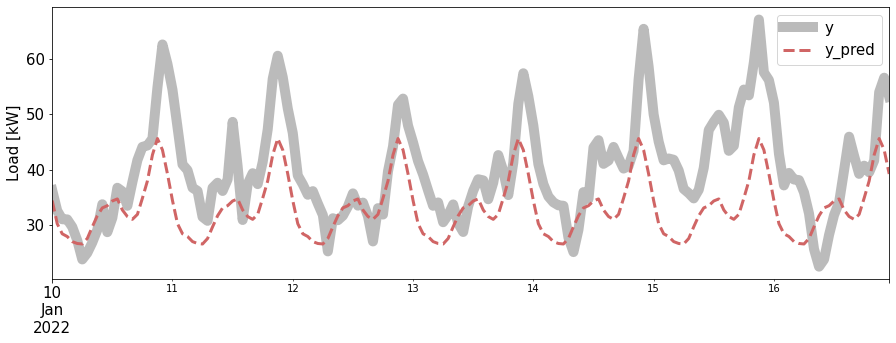

In [6]:
# CREATE FEATURES
X_arr = hour_dummies.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression(fit_intercept=False).fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_hour = y_pred.copy()  # for later comparison
print_mape(y, y_pred)

## GRAFICO DE UNA SEMANA CUALQUIERA ##
indices = y["2022-01-10": "2022-01-16"].index

y.loc[indices].plot(figsize=[15, 5], lw=10, alpha=0.5, color=grey, legend=True);
y_pred.loc[indices].plot(lw=3, ls="--", color=red, legend=True);
plt.xticks(fontsize=15), plt.yticks(fontsize=15)
plt.xlabel(""), plt.ylabel("Load [kW]", fontsize=15);
plt.legend(fontsize=15);


Debido que el modelo no puede distinguir entre los distintos meses y los distintos días, esto lleva a la misma predicción durante todo el tiempo 

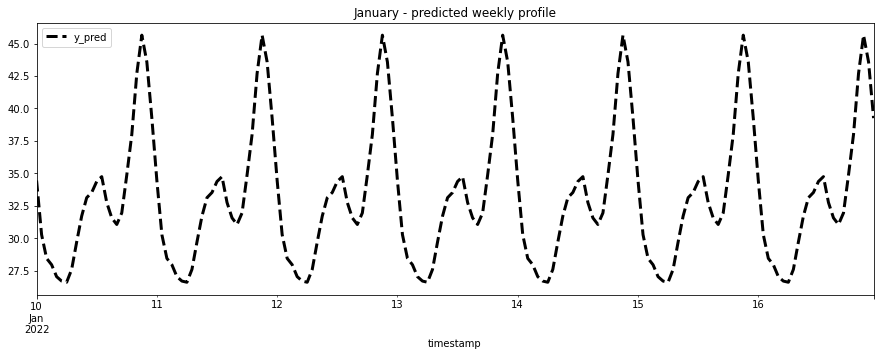

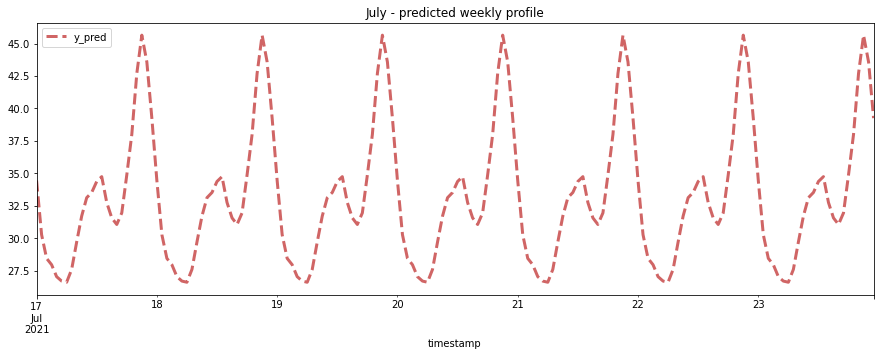

In [7]:
indices_january = y["2022-01-10": "2022-01-16"].index
indices_july = y["2021-07-17": "2021-07-23"].index


fig = plt.figure(figsize=[15, 5])
y_pred_hour.loc[indices_january].plot(lw=3, ls="--", color="k", legend=True);
plt.title("January - predicted weekly profile")

fig = plt.figure(figsize=[15, 5])
y_pred_hour.loc[indices_july].plot(lw=3, ls="--", color=red, legend=True);
plt.title("July - predicted weekly profile");

### 1.2. Contemplando el Mes + Día de la semana + Hora del día

In [8]:
# CREATE FEATURES
X = pd.concat([month_dummies.iloc[:, :-1],  # exclude the last category
               day_dummies.iloc[:, :-1],    # exclude the last category
               hour_dummies.iloc[:, :-1]    # exclude the last category
              ], axis=1)
X_arr = X.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_mdh = y_pred.copy()  # for later comparison
print_mape(y, y_pred)

y_pred.head(2)


X dimensions: (8761, 40), y dimensions: (8761, 1)
MAPE: 15.556 %


timestamp
2021-03-21 00:00:00    26.165341
2021-03-21 01:00:00    21.968483
Freq: H, Name: y_pred, dtype: float64

### 1.3. Contemplando el Mes + Día de la semana x Hora del día

In [9]:
# CREATE FEATURES
X = pd.concat([month_dummies.iloc[:, :-1],      # exclude the last category
               dayhour_dummies.iloc[:, :-1],    # exclude the last category
              ], axis=1)
X_arr = X.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_mdxh = y_pred.copy()  # para una posterior comparación
print_mape(y, y_pred)

y_pred.head(2)

X dimensions: (8761, 178), y dimensions: (8761, 1)
MAPE: 15.414 %


timestamp
2021-03-21 00:00:00    27.715662
2021-03-21 01:00:00    23.442544
Freq: H, Name: y_pred, dtype: float64

### 1.4. Contemplando el Mes + Día de la semana + Hora del día

In [10]:
preds = pd.concat([y_pred_hour.rename("hour"),
                   y_pred_mdh.rename("month + day + hour"),
                   y_pred_mdxh.rename("month + day x hour")
                  ], axis=1)

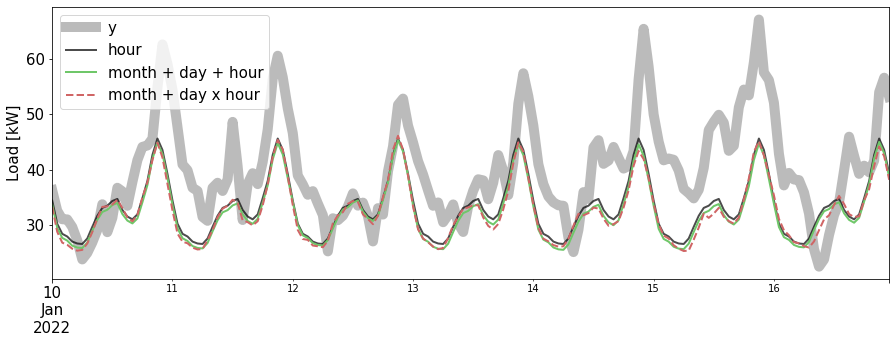

In [11]:
indices = y["2022-01-10": "2022-01-16"].index

y.loc[indices].plot(figsize=[15, 5], lw=10, alpha=0.5, color=grey, legend=True);
preds.loc[indices, "hour"].plot(lw=2, ls="-", color="k", alpha=0.7, legend=True);
preds.loc[indices, "month + day + hour"].plot(lw=2, ls="-", color=green, legend=True);
preds.loc[indices, "month + day x hour"].plot(lw=2, ls="--", color=red, legend=True);
plt.xticks(fontsize=15), plt.yticks(fontsize=15)
plt.xlabel(""), plt.ylabel("Load [kW]", fontsize=15);
plt.legend(fontsize=15);

## 2. Modelo con la Temperatura
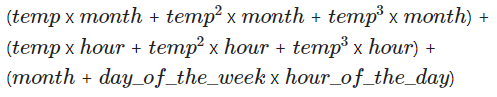


In [12]:
# CREATE FEATURES
X = pd.concat([month_dummies.iloc[:, :],  
               dayhour_dummies.iloc[:, :],    
               # month interactions
               get_interactions(temp, month_dummies, poly_degree=3),
               # hourly interactions
               get_interactions(temp, hour_dummies, poly_degree=3)   
              ], axis=1)
X_arr = X.values
y_arr = y.values.reshape(-1, 1)
print("X dimensions: {}, y dimensions: {}".format(X_arr.shape, y_arr.shape))

mlr = LinearRegression().fit(X_arr, y_arr)
y_pred = pd.Series(mlr.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_mdxh = y_pred.copy()  # para una comparación posterior
print_mape(y, y_pred)

rdf = RandomForestRegressor().fit(X_arr, y_arr)
y_pred2 = pd.Series(rdf.predict(X_arr).flatten(), index=y.index, name="y_pred")
y_pred_mdxh2 = y_pred2.copy()  # Para una comparación posterior
print_mape(y, y_pred2)

y_pred.head(2)

X dimensions: (8761, 288), y dimensions: (8761, 1)
MAPE: 11.099 %
MAPE: 4.654 %


timestamp
2021-03-21 00:00:00    27.164768
2021-03-21 01:00:00    21.688854
Freq: H, Name: y_pred, dtype: float64

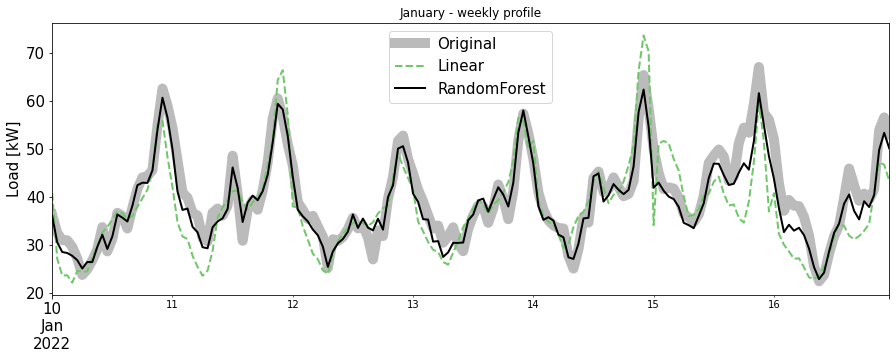

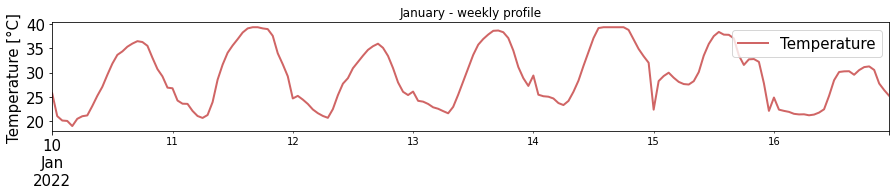

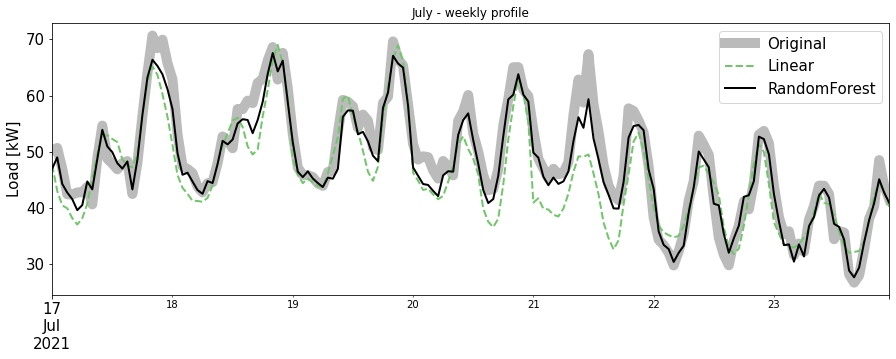

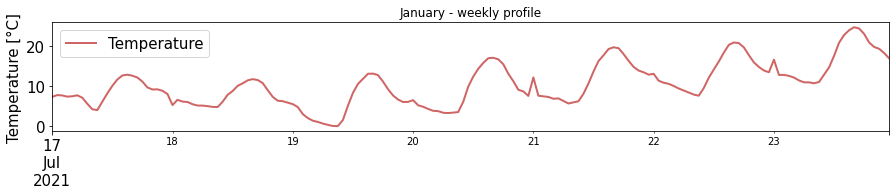

In [13]:
indices_january = y["2022-01-10": "2022-01-16"].index
indices_july = y["2021-07-17": "2021-07-23"].index

# Ajuste de los modelos en mes de ENERO
fig, ax1 = plt.subplots(figsize=[15, 5])

y.loc[indices_january].plot(figsize=[15, 5], lw=10, alpha=0.5, color=grey, legend=True, label='Original');
y_pred_mdxh.loc[indices_january].plot(lw=2, ls="--", color=green, legend=True, label='Linear');
y_pred_mdxh2.loc[indices_january].plot(lw=2, ls="-", color="k", legend=True, label='RandomForest');

plt.title("January - weekly profile")
plt.xticks(fontsize=15), plt.yticks(fontsize=15)
plt.xlabel(""), plt.ylabel("Load [kW]", fontsize=15);
plt.legend(fontsize=15);

fig, ax1 = plt.subplots(figsize=[15, 2])
temp.loc[indices_january].plot(lw=2, ls="-", color=red, legend=True, label='Temperature');
plt.title("January - weekly profile")
plt.xticks(fontsize=15), plt.yticks(fontsize=15)
plt.xlabel(""), plt.ylabel("Temperature [°C]", fontsize=15);
plt.legend(fontsize=15);

# Ajuste de los modelos en mes de Julio
fig, ax1 = plt.subplots(figsize=[15, 5])

y.loc[indices_july].plot(figsize=[15, 5], lw=10, alpha=0.5, color=grey, legend=True, label='Original');
y_pred_mdxh.loc[indices_july].plot(lw=2, ls="--", color=green, legend=True, label='Linear');
y_pred_mdxh2.loc[indices_july].plot(lw=2, ls="-", color="k", legend=True, label='RandomForest');

plt.title("July - weekly profile");
plt.xticks(fontsize=15), plt.yticks(fontsize=15)
plt.xlabel(""), plt.ylabel("Load [kW]", fontsize=15);
plt.legend(fontsize=15);

fig, ax1 = plt.subplots(figsize=[15, 2])
temp.loc[indices_july].plot(lw=2, ls="-", color=red, legend=True, label='Temperature');
plt.title("January - weekly profile")
plt.xticks(fontsize=15), plt.yticks(fontsize=15)
plt.xlabel(""), plt.ylabel("Temperature [°C]", fontsize=15);
plt.legend(fontsize=15);


## 3. VALIDACIÓN DEL MODELO

Se analizan las estaciones del año por separado.

In [14]:
summer = y["2021-12-21": "2022-03-21"].index.rename('summer')
autum =  y["2021-03-21": "2021-06-21"].index.rename('autum')
winter = y["2021-06-21": "2021-09-21"].index.rename('winter')
spring = y["2021-09-21": "2021-12-21"].index.rename('spring')

seasons=[summer,autum,winter,spring]

Se divide el dataset en 80/20: 80% de los datos para entrenar el modelo y 20% para validarlo. Los datos de validación se eligen de manera aleatoria.

In [15]:
from sklearn.model_selection import train_test_split
s=0

for i in seasons:
    
    x_train,x_test,Y_train,Y_test = train_test_split(X.loc[i], y.loc[i], test_size=0.20, random_state=4)
    
    print(seasons[s].name)
    print('Observations: %d' % (len(y.loc[i])))
    print('Training Observations: %d' % (len(Y_train)))
    print('Testing Observations: %d \n' % (len(Y_test)))
   
    s+=1  

summer
Observations: 2161
Training Observations: 1728
Testing Observations: 433 

autum
Observations: 2232
Training Observations: 1785
Testing Observations: 447 

winter
Observations: 2232
Training Observations: 1785
Testing Observations: 447 

spring
Observations: 2208
Training Observations: 1766
Testing Observations: 442 



Se estima la demanda y se calcula el error (MAPE y RMSE) respecto a los datos de validación.

In [16]:
s=0
n=0
for i in seasons:
    
    x_train,x_test,Y_train,Y_test = train_test_split(X.loc[i], y.loc[i], test_size=0.20, random_state=4)

    print(seasons[s].name)
    X_arr = x_train.values
    y_arr = Y_train.values.reshape(-1, 1)     
        
    mlr = LinearRegression().fit(X_arr, y_arr)
    y_pred = pd.Series(mlr.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
    print('Regresión lineal multiple')
    print_mape(Y_test, y_pred)
    print_rmse(Y_test, y_pred)
    
    rdf = RandomForestRegressor(random_state=1).fit(X_arr, y_arr) ## Random Forest con parametros por default
    y_pred2 = pd.Series(rdf.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
    print('Random forest')
    print_mape(Y_test, y_pred2)
    print_rmse(Y_test, y_pred2)
    print('\n')
    s+=1

summer
Regresión lineal multiple
MAPE: 10.565 %
RMSE: 4.243 %
Random forest
MAPE: 10.284 %
RMSE: 4.309 %


autum
Regresión lineal multiple
MAPE: 11.476 %
RMSE: 4.664 %
Random forest
MAPE: 12.495 %
RMSE: 5.116 %


winter
Regresión lineal multiple
MAPE: 12.978 %
RMSE: 6.419 %
Random forest
MAPE: 12.867 %
RMSE: 6.455 %


spring
Regresión lineal multiple
MAPE: 11.994 %
RMSE: 4.473 %
Random forest
MAPE: 12.251 %
RMSE: 4.398 %




# ANEXO: coeficientes de los modelos implementados

## Random Forest : max_features

### Hiper-parametros
Los inputs más importantes en Random Forest son los siguientes:

1. n_estimators: cantidad de árboles a construir (100)
2. max_depth: máxima profundidad de cada arbol (None)
3. min_samples_split: cantidad mínima de datos requeridos para splitear un nodo interno (2)
4. min_samples_leaf: cantidad mínima de datos requeridos para ser una hoja (1)
5. max_features: la cantidad de features a considerar cuando se busca el mejor split (n)

Se ajusta el modelo parametrizando la variable input "max_features", que indica el número de predictores (features) a considerar cuando se buca el mejor split. Es decir, en cada arbol de Random Forest, se realiza una selección aleatoria de los predictores y con este parametro podemos modificar qué cantidad se utiliza para cada arbol.


In [17]:
max_features = [int(x) for x in np.linspace(start = 1, stop = 200, num = 20)]

def print_mape(y_true, y_pred):

    error = y_true - y_pred
    mape = (100 * error.abs() / y_true).mean()
    return mape
    
inertias_sum=[]
inertias_aut=[]
inertias_win=[]
inertias_spr=[]

s=0

for i in seasons:
    x_train,x_test,Y_train,Y_test = train_test_split(X.loc[i], y.loc[i], test_size=0.20, random_state=4)
    
    if seasons[s].name == 'summer':
        X_arr = x_train.values
        y_arr = Y_train.values.reshape(-1, 1)
    
        for x in max_features:
            rdf = RandomForestRegressor(random_state=1, max_features =x).fit(X_arr, y_arr)
            y_pred2 = pd.Series(rdf.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
            inertias_sum.append(print_mape(Y_test, y_pred2))
    
    if seasons[s].name == 'autum':
        X_arr = x_train.values
        y_arr = Y_train.values.reshape(-1, 1)
    
        for x in max_features:
            rdf = RandomForestRegressor(random_state=1, max_features =x).fit(X_arr, y_arr)
            y_pred2 = pd.Series(rdf.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
            inertias_aut.append(print_mape(Y_test, y_pred2))    
    
    if seasons[s].name == 'winter':
        X_arr = x_train.values
        y_arr = Y_train.values.reshape(-1, 1)
    
        for x in max_features:
            rdf = RandomForestRegressor(random_state=1, max_features =x).fit(X_arr, y_arr)
            y_pred2 = pd.Series(rdf.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
            inertias_win.append(print_mape(Y_test, y_pred2))    
            
    if seasons[s].name == 'spring':
        X_arr = x_train.values
        y_arr = Y_train.values.reshape(-1, 1)
    
        for x in max_features:
            rdf = RandomForestRegressor(random_state=1, max_features =x).fit(X_arr, y_arr)
            y_pred2 = pd.Series(rdf.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
            inertias_spr.append(print_mape(Y_test, y_pred2))               
    s+=1
    

summer - el max_feature es: 189 ,con un mínimo MAPE: 10.25777389028839
autum  - el max_feature es: 11 ,con un mínimo MAPE: 12.45316570472402
spring - el max_feature es: 53 ,con un mínimo MAPE: 12.012887242300751
winter - el max_feature es: 158 ,con un mínimo MAPE: 12.693077617761093


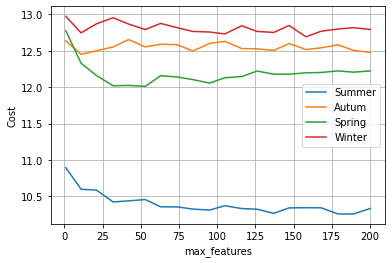

In [18]:
inertias_sum=pd.Series(inertias_sum, index=max_features)
inertias_sum.plot(grid=True,label='Summer');
plt.xlabel("max_features",)
plt.ylabel("Cost");

inertias_aut=pd.Series(inertias_aut, index=max_features)
inertias_aut.plot(grid=True,label='Autum');
plt.xlabel("max_features")
plt.ylabel("Cost");

inertias_spr=pd.Series(inertias_spr, index=max_features)
inertias_spr.plot(grid=True,label='Spring');
plt.xlabel("max_features")
plt.ylabel("Cost");

inertias_win=pd.Series(inertias_win, index=max_features)
inertias_win.plot(grid=True,label='Winter');
plt.xlabel("max_features")
plt.ylabel("Cost");

plt.legend()

print('summer - el max_feature es:',inertias_sum.idxmin(),',con un mínimo MAPE:',inertias_sum.min())
print('autum  - el max_feature es:',inertias_aut.idxmin(),',con un mínimo MAPE:',inertias_aut.min())
print('spring - el max_feature es:',inertias_spr.idxmin(),',con un mínimo MAPE:',inertias_spr.min())
print('winter - el max_feature es:',inertias_win.idxmin(),',con un mínimo MAPE:',inertias_win.min())

## Regresión lineal múltiple : coeficientes beta

Un gran beneficio del método de Regresión Lineal Múltiple es que resulta bastante claro que se está aprendiendo: un coeficiente por cada X (input). Se puede plotear, facilmente, los coeficientes del modelo, algo que no sería posible para el Random Forest.

In [19]:
s=0
n=0
s=0

for i in seasons:
    x_train,x_test,Y_train,Y_test = train_test_split(X.loc[i], y.loc[i], test_size=0.20, random_state=4)
    
    if seasons[s].name == 'summer':
        X_arr = x_train.values
        y_arr = Y_train.values.reshape(-1, 1)
    
        mlr = LinearRegression().fit(X_arr, y_arr)
        y_pred = pd.Series(mlr.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
        
        coef_sum = mlr.coef_
        cons_sum = mlr.intercept_

        coef_df_sum = pd.DataFrame(coef_sum.T, x_train.columns, columns=['Coefficient'])
        
    if seasons[s].name == 'autum':
        X_arr = x_train.values
        y_arr = Y_train.values.reshape(-1, 1)
        
        mlr = LinearRegression().fit(X_arr, y_arr)
        y_pred = pd.Series(mlr.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
    
        coef_aut = mlr.coef_
        cons_aut = mlr.intercept_

        coef_df_aut = pd.DataFrame(coef_aut.T, x_train.columns, columns=['Coefficient'])   
    
    if seasons[s].name == 'winter':
        X_arr = x_train.values
        y_arr = Y_train.values.reshape(-1, 1)
    
        mlr = LinearRegression().fit(X_arr, y_arr)
        y_pred = pd.Series(mlr.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
    
        coef_win = mlr.coef_
        cons_win = mlr.intercept_

        coef_df_win = pd.DataFrame(coef_win.T, x_train.columns, columns=['Coefficient'])  
            
    if seasons[s].name == 'spring':
        X_arr = x_train.values
        y_arr = Y_train.values.reshape(-1, 1)
    
        mlr = LinearRegression().fit(X_arr, y_arr)
        y_pred = pd.Series(mlr.predict(x_test).flatten(), index=Y_test.index, name="y_pred")
    
        coef_spr = mlr.coef_
        cons_spr = mlr.intercept_

        coef_df_spr = pd.DataFrame(coef_spr.T, x_train.columns, columns=['Coefficient'])              
    s+=1
    
    

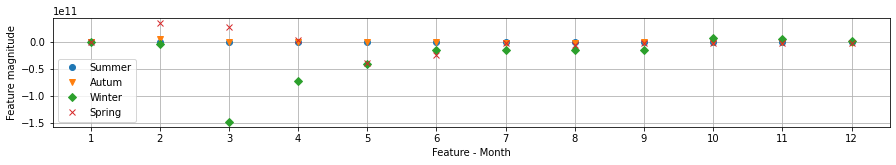

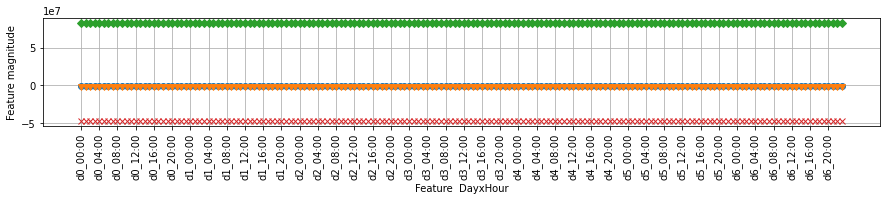

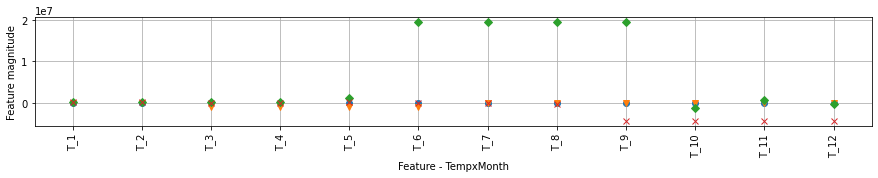

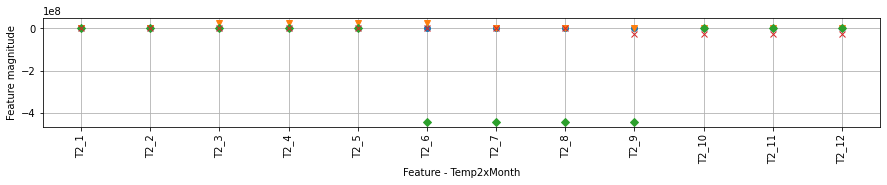

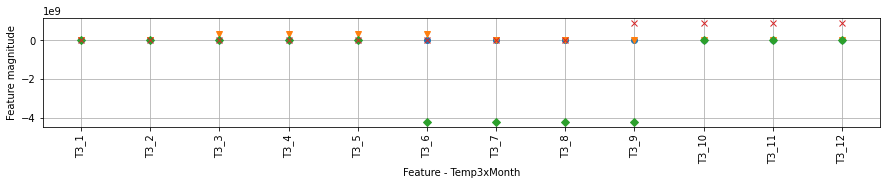

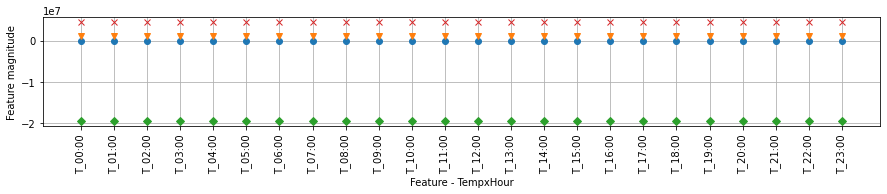

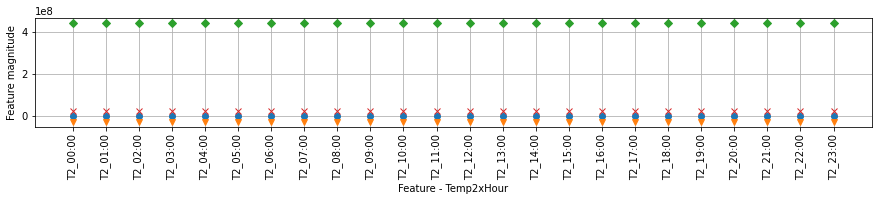

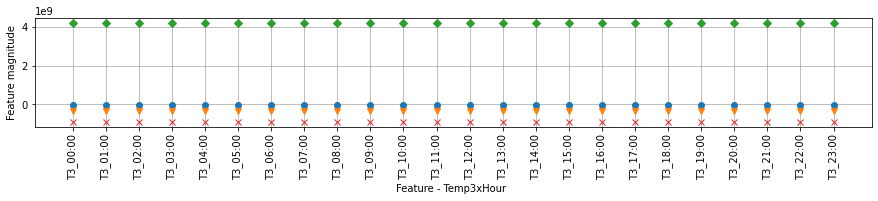

In [20]:
#Coeficientes mes
plt.figure(figsize=(15, 2))
plt.plot(coef_df_sum.loc[month_dummies.iloc[:, :].columns], 'o',label='Summer')
plt.plot(coef_df_aut.loc[month_dummies.iloc[:, :].columns], 'v',label='Autum')
plt.plot(coef_df_win.loc[month_dummies.iloc[:, :].columns], 'D',label='Winter')
plt.plot(coef_df_spr.loc[month_dummies.iloc[:, :].columns], 'x',label='Spring')

plt.xticks(np.arange(1,len(coef_df_sum.loc[month_dummies.iloc[:, :].columns])+1,1),rotation=0)
plt.ylabel("Feature magnitude")
plt.xlabel("Feature - Month")
plt.legend()
plt.grid()

#Coeficientes hora x día
plt.figure(figsize=(15, 2))
plt.plot(coef_df_sum.loc[dayhour_dummies.iloc[:, :].columns], 'o',label='Summer')
plt.plot(coef_df_aut.loc[dayhour_dummies.iloc[:, :].columns], 'v',label='Autum')
plt.plot(coef_df_win.loc[dayhour_dummies.iloc[:, :].columns], 'D',label='Winter')
plt.plot(coef_df_spr.loc[dayhour_dummies.iloc[:, :].columns], 'x',label='Spring')

plt.xticks(np.arange(0,len(dayhour_dummies.iloc[:, :].columns),4),  rotation=90)
plt.ylabel("Feature magnitude")
plt.xlabel("Feature  DayxHour")
plt.grid()

#Coeficientes Temp x mes
plt.figure(figsize=(15, 2))
plt.plot(coef_df_sum.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T_1":"T_12"].columns], 'o',label='Summer')
plt.plot(coef_df_aut.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T_1":"T_12"].columns], 'v',label='Autum')
plt.plot(coef_df_win.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T_1":"T_12"].columns], 'D',label='Winter')
plt.plot(coef_df_spr.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T_1":"T_12"].columns], 'x',label='Spring')
plt.xticks(np.arange(0,len(get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T_1":"T_12"].columns),1),  rotation=90)
plt.ylabel("Feature magnitude")
plt.xlabel("Feature - TempxMonth")
plt.grid()

plt.figure(figsize=(15, 2))
plt.plot(coef_df_sum.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T2_1":"T2_12"].columns], 'o',label='Summer')
plt.plot(coef_df_aut.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T2_1":"T2_12"].columns], 'v',label='Autum')
plt.plot(coef_df_win.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T2_1":"T2_12"].columns], 'D',label='Winter')
plt.plot(coef_df_spr.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T2_1":"T2_12"].columns], 'x',label='Spring')
plt.xticks(np.arange(0,len(get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T2_1":"T2_12"].columns),1),  rotation=90)
plt.ylabel("Feature magnitude")
plt.xlabel("Feature - Temp2xMonth")
plt.grid()

plt.figure(figsize=(15, 2))
plt.plot(coef_df_sum.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T3_1":"T3_12"].columns], 'o',label='Summer')
plt.plot(coef_df_aut.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T3_1":"T3_12"].columns], 'v',label='Autum')
plt.plot(coef_df_win.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T3_1":"T3_12"].columns], 'D',label='Winter')
plt.plot(coef_df_spr.loc[get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T3_1":"T3_12"].columns], 'x',label='Spring')
plt.xticks(np.arange(0,len(get_interactions(temp, month_dummies, poly_degree=3).loc[:,"T3_1":"T3_12"].columns),1),  rotation=90)
plt.ylabel("Feature magnitude")
plt.xlabel("Feature - Temp3xMonth")
plt.grid()


#Coeficientes Temp x hora
plt.figure(figsize=(15, 2))
plt.plot(coef_df_sum.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T_00:00":"T_23:00"].columns], 'o',label='Summer')
plt.plot(coef_df_aut.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T_00:00":"T_23:00"].columns], 'v',label='Autum')
plt.plot(coef_df_win.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T_00:00":"T_23:00"].columns], 'D',label='Winter')
plt.plot(coef_df_spr.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T_00:00":"T_23:00"].columns], 'x',label='Spring')
plt.xticks(np.arange(0,len(get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T_00:00":"T_23:00"].columns),1),  rotation=90)
plt.ylabel("Feature magnitude")
plt.xlabel("Feature - TempxHour")
plt.grid()

plt.figure(figsize=(15, 2))
plt.plot(coef_df_sum.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T2_00:00":"T2_23:00"].columns], 'o',label='Summer')
plt.plot(coef_df_aut.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T2_00:00":"T2_23:00"].columns], 'v',label='Autum')
plt.plot(coef_df_win.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T2_00:00":"T2_23:00"].columns], 'D',label='Winter')
plt.plot(coef_df_spr.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T2_00:00":"T2_23:00"].columns], 'x',label='Spring')
plt.xticks(np.arange(0,len(get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T2_00:00":"T2_23:00"].columns),1),  rotation=90)
plt.ylabel("Feature magnitude")
plt.xlabel("Feature - Temp2xHour")
plt.grid()

plt.figure(figsize=(15, 2))
plt.plot(coef_df_sum.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T3_00:00":"T3_23:00"].columns], 'o',label='Summer')
plt.plot(coef_df_aut.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T3_00:00":"T3_23:00"].columns], 'v',label='Autum')
plt.plot(coef_df_win.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T3_00:00":"T3_23:00"].columns], 'D',label='Winter')
plt.plot(coef_df_spr.loc[get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T3_00:00":"T3_23:00"].columns], 'x',label='Spring')
plt.xticks(np.arange(0,len(get_interactions(temp, hour_dummies, poly_degree=3).loc[:,"T3_00:00":"T3_23:00"].columns),1),  rotation=90)
plt.ylabel("Feature magnitude")
plt.xlabel("Feature - Temp3xHour ")
plt.grid()

